In [1]:
from pathlib import Path
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from capture_simulation import get_f_g
from scipy.stats import circmean, circstd, combine_pvalues, anderson_ksamp, ks_2samp, vonmises
from astropy.stats import kuiper_two
from hammy import resonance_width
plt.rcParams['font.size'] = 16

In [2]:
def T0_to_lambda0(P, T0, ecosw, esinw):
    e = np.sqrt(ecosw**2 + esinw**2)
    omega = np.arctan2(esinw, ecosw)
    f0 = np.pi/2 - omega
    E0 = 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(f0/2))
    M0 = E0 - e*np.sin(E0)
    M = M0 - 2*np.pi/P*T0
    return M + omega

def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/len(xs)
    return xs, ys

In [3]:
koi_cum = pd.read_csv('data/cumulative_2022.11.08_21.00.11.csv', comment='#', index_col=0)
koi_cum['koi_name'] = 'KOI-' + koi_cum['kepoi_name'].str.split('.', expand=True)[0].str.removeprefix('K0')
# table is missing some planets
koi_cum.loc[koi_cum.index.max() + 1] = {'koi_name':'KOI-1353', 'koi_period':66.0634,'koi_prad':2.68}
hl17_ttv_data = h5py.File('data/NBody_MCMC_Posteriors.hdf5')
jh21_post_dir = Path('data/TTVposteriors')

In [4]:
def read_HL17_system(system, pl, ret_mult=False):
    pair = hl17_ttv_data[f'{system}/DefaultPriors/PosteriorSample']
    if ret_mult:
        return pair.shape[1]//5
    m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02 = pair[:,pl].T
    start = 0 if pl.start is None else pl.start//5
    return m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02

def read_JH21_system(system, pair, ret_mult=False):
    path = (jh21_post_dir / system).with_suffix('.dat')
    N_pl = len(pd.read_csv(path, delim_whitespace=True, header=None).columns)//5
    if ret_mult:
        return N_pl
    df = pd.read_csv(path, header=None, delim_whitespace=True)
    m1, P1, esinw1, ecosw1, T01 = df.iloc[:,pair[0]*5:pair[0]*5+5].values.T
    m2, P2, esinw2, ecosw2, T02 = df.iloc[:,pair[1]*5:pair[1]*5+5].values.T
    # they give in Earth masses
    m1 /= 332900
    m2 /= 332900
    return m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02

Period ratio: 1.1611
Osculating Delta = -0.00479
mean phi_1 = 0.3645 std phi_1 = 2.2575
mean phi_2 = 4.8321 std phi_2 = 2.1262
mean psi: 4.3713, std psi: 0.4169


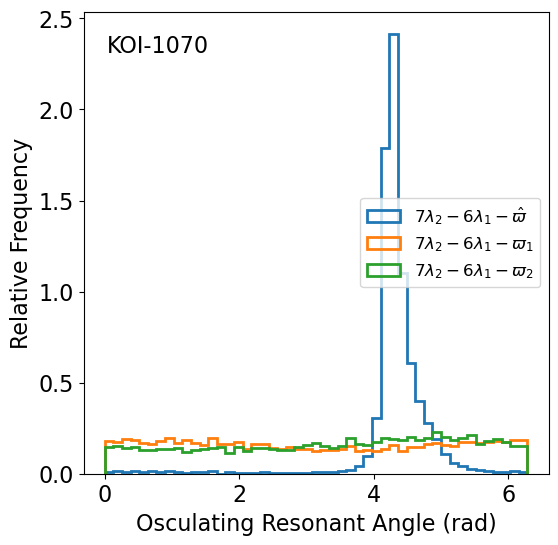

In [5]:
system = 'KOI-1070'
if 'Kepler' in system:
    m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02 = read_HL17_system(system, slice(0,10))
else:
    m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02 = read_JH21_system(system, (1,2))
# uncomment to shuffle posterior and remove correlations
# list(map(np.random.shuffle, [m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02]))
print(f'Period ratio: {(P2/P1).mean():.4f}')
p = 7
f, g = get_f_g(p, 1)
lambda2 = T0_to_lambda0(P2, T02, ecosw2, esinw2)
lambda1 = T0_to_lambda0(P1, T01, ecosw1, esinw1)
print(f'Osculating Delta = {P2.mean()/P1.mean()/(p/(p-1)) - 1:.5f}')
theta_res = p*lambda2 - (p-1)*lambda1
phi_1 = np.remainder(theta_res - np.arctan2(esinw1, ecosw1), 2*np.pi)
phi_2 = np.remainder(theta_res - np.arctan2(esinw2, ecosw2), 2*np.pi)
psi = np.remainder(theta_res - np.angle(f*(ecosw1 + 1j*esinw1) + g*(ecosw2 + 1j*esinw2)), 2*np.pi)
plt.figure(figsize=(6,6))
for angle, label in zip([psi, phi_1, phi_2], 
                        [rf'${p}\lambda_2 - {p-1}\lambda_1-\hat{{\varpi}}$', 
                         rf'${p}\lambda_2 - {p-1}\lambda_1-\varpi_1$', 
                         rf'${p}\lambda_2 - {p-1}\lambda_1-\varpi_2$']):
    plt.hist(angle, bins=np.linspace(0, 2*np.pi, 50), 
    label=label, density=True, histtype='step', lw=2)
plt.xlabel('Osculating Resonant Angle (rad)')
plt.ylabel('Relative Frequency')
print(f'mean phi_1 = {circmean(phi_1):.4f}', f'std phi_1 = {circstd(phi_1):.4f}')
print( f'mean phi_2 = {circmean(phi_2):.4f}', f'std phi_2 = {circstd(phi_2):.4f}')
print(f'mean psi: {circmean(psi):.4f}, std psi: {circstd(psi):.4f}')
plt.text(0.05, 0.95, system, transform=plt.gca().transAxes, va='top')
plt.legend(loc='right', fontsize=12)

In [6]:
HL17_systems = [('Kepler-9', slice(None), '2:1'),
                ('Kepler-11', slice(0,10), '5:4'),
                ('Kepler-11', slice(15,25), '3:2'),
                ('Kepler-18', slice(None), '2:1'),
                ('Kepler-23', slice(0,10), '3:2'),
                ('Kepler-23', slice(5,15), '3:2'),
                ('Kepler-24', slice(0,10), '3:2'),
                ('Kepler-24', slice(5,15), '3:2'),
                ('Kepler-25', slice(None), '2:1'),
                ('Kepler-27', slice(0,10), '2:1'),
                ('Kepler-27', slice(5,15), '2:1'),
                ('Kepler-28', slice(None), '3:2'), 
                ('Kepler-30', slice(None), '2:1'),
                ('Kepler-31', slice(0,10), '2:1'),
                ('Kepler-31', slice(5,15), '2:1'),
                ('Kepler-32', slice(None), '3:2'), 
                ('Kepler-33', slice(5,15), '3:2'),
                ('Kepler-48', slice(None), '2:1'),
                ('Kepler-49', slice(None), '3:2'), 
                ('Kepler-51', slice(0,10), '2:1'),
                ('Kepler-51', slice(5,15), '3:2'),
                ('Kepler-52', slice(0,10), '2:1'),
                ('Kepler-52', slice(5,15), '2:1'),
                ('Kepler-53', slice(0,10), '2:1'),
                ('Kepler-53', slice(5,15), '2:1'),
                ('Kepler-54', slice(0,10), '3:2'),
                ('Kepler-55', slice(None), '3:2'), 
                ('Kepler-56', slice(None), '2:1'),
                ('Kepler-57', slice(None), '2:1'),
                ('Kepler-58', slice(None), '3:2'),
                ('Kepler-60', slice(0,10), '5:4'),
                ('Kepler-60', slice(5,15), '4:3'),
                ('Kepler-79', slice(0,10), '2:1'),
                ('Kepler-79', slice(5,15), '2:1'),
                ('Kepler-79', slice(10,20), '3:2'),
                ('Kepler-80', slice(0,10), '3:2'), 
                ('Kepler-80', slice(5,15), '3:2'),
                ('Kepler-80', slice(10,20), '4:3'),
                ('Kepler-81', slice(0,10), '2:1'),
                ('Kepler-84', slice(0,10), '2:1'),
                ('Kepler-84', slice(5,15), '3:2'),
                ('Kepler-84', slice(10,20), '2:1'),
                ('Kepler-85', slice(0,10), '3:2'),
                ('Kepler-89', slice(None), '2:1'),
                ('Kepler-105', slice(0,10), '3:2'),
                ('Kepler-105', slice(5,15), '4:3'),
                ('Kepler-114', slice(0,10), '3:2'),
                ('Kepler-114', slice(5,15), '3:2'),
                ('Kepler-122', slice(None), '3:2'), 
                ('Kepler-127', slice(0,10), '2:1'),
                ('Kepler-128', slice(None), '3:2'),
                ('Kepler-138', slice(0,10), '4:3'),
                ('Kepler-176', slice(None), '2:1'),
                ('Kepler-177', slice(None), '4:3'),
                ('Kepler-223', slice(0,10), '4:3'),
                ('Kepler-223', slice(5,15), '3:2'),
                ('Kepler-223', slice(10,20), '4:3'),
                ('Kepler-238', slice(0,10), '2:1'),
                ('Kepler-238', slice(10,20), '2:1'),
                ('Kepler-277', slice(None), '2:1'),
                ('Kepler-279', slice(None), '3:2'), 
                ('Kepler-305', slice(5,15), '3:2'),
                ('Kepler-305', slice(10,20), '2:1'),
                ('Kepler-307', slice(None), '5:4'),
                ('Kepler-324', slice(None), '3:2'),
                ('Kepler-345', slice(None), '5:4'),
                ('Kepler-359', slice(None), '4:3'),
                ('Kepler-396', slice(None), '2:1'),
                ('Kepler-444', slice(0,10), '5:4'),
                ('Kepler-444', slice(5,15), '4:3'),
                ('Kepler-444', slice(10,20), '5:4'),
                ('Kepler-444', slice(15,25), '5:4'),
                ('Kepler-526', slice(None), '5:4'),
                ('Kepler-1126', slice(None), '2:1')]

koi_lookup = {'Kepler-9':'KOI-0377', 'Kepler-11':'KOI-0157', 'Kepler-18':'KOI-0137', 'Kepler-23':'KOI-0168', 
'Kepler-24':'KOI-1102', 'Kepler-25':'KOI-0244', 'Kepler-27':'KOI-0841', 'Kepler-28':'KOI-0870', 'Kepler-30':'KOI-0806',
'Kepler-31':'KOI-0935', 'Kepler-32':'KOI-0952', 'Kepler-33':'KOI-0707', 'Kepler-48':'KOI-0148', 'Kepler-49':'KOI-0248',
'Kepler-51':'KOI-0620', 'Kepler-52':'KOI-0775', 'Kepler-53':'KOI-0829', 'Kepler-54':'KOI-0886', 'Kepler-55':'KOI-0904',
'Kepler-56':'KOI-1241', 'Kepler-57':'KOI-1270', 'Kepler-58':'KOI-1336', 'Kepler-60':'KOI-2086', 'Kepler-79':'KOI-0152',
'Kepler-80':'KOI-0500', 'Kepler-81':'KOI-0877', 'Kepler-84':'KOI-1589', 'Kepler-85':'KOI-2038', 'Kepler-89':'KOI-0094',
'Kepler-105':'KOI-0115', 'Kepler-114':'KOI-0156', 'Kepler-122':'KOI-0232', 'Kepler-127':'KOI-0271', 'Kepler-128':'KOI-0274',
'Kepler-138':'KOI-0314', 'Kepler-176':'KOI-0520', 'Kepler-177':'KOI-0523', 'Kepler-223':'KOI-0730', 'Kepler-238':'KOI-0834',
'Kepler-277':'KOI-1215', 'Kepler-279':'KOI-1236', 'Kepler-305':'KOI-1563', 'Kepler-307':'KOI-1576', 'Kepler-324':'KOI-1831',
'Kepler-345':'KOI-1977', 'Kepler-359':'KOI-2092', 'Kepler-396':'KOI-2672', 'Kepler-444':'KOI-3158', 'Kepler-526':'KOI-0332',
'Kepler-1126':'KOI-2162'}


JH21_only_systems = [('KOI-0085', (1,2), '4:3'),
                     ('KOI-0137', (0,1), '2:1'),
                     ('KOI-0222', (0,1), '2:1'),
                     ('KOI-0250', (1,2), '4:3'),
                     ('KOI-0255', (0,1), '2:1'),
                     ('KOI-0277', (0,1), '7:6'),
                     ('KOI-0401', (0,1), '2:1'),
                     ('KOI-0430', (0,1), '4:3'),
                     ('KOI-0457', (0,1), '3:2'),
                     ('KOI-0567', (0,1), '2:1'),
                     ('KOI-0567', (1,2), '3:2'),
                     ('KOI-0520', (2,3), '2:1'),
                     ('KOI-0654', (0,1), '6:5'),
                     ('KOI-0738', (0,1), '5:4'),
                     ('KOI-0750', (1,2), '3:2'),
                     ('KOI-0934', (0,1), '2:1'),
                     ('KOI-0934', (1,2), '3:2'),
                     ('KOI-1070', (1,2), '7:6'),
                     ('KOI-1279', (0,1), '3:2'),
                     ('KOI-1338', (1,2), '2:1'),
                     ('KOI-1353', (0,1), '2:1'),
                     ('KOI-1353', (1,2), '2:1'),
                     ('KOI-1599', (0,1), '3:2'),
                     ('KOI-1783', (0,1), '2:1'),
                     ('KOI-1833', (0,1), '3:2'),
                     ('KOI-1833', (1,2), '4:3'),
                     ('KOI-1955', (2,3), '3:2'),
                     ('KOI-2092', (1,2), '4:3'),
                     ('KOI-2113', (0,1), '4:3'),
                     ('KOI-2174', (0,1), '2:1'),
                     ('KOI-2174', (1,2), '7:6'),
                     ('KOI-2195', (1,2), '3:2'),
                     ('KOI-2414', (0,1), '2:1'),
                     ('KOI-3503', (0,1), '3:2')]

In [7]:
Y1_df = {'System':[], 'res':[], 'Delta':[], 'mult':[], 'Z_all':[], 'Zabs_all':[], 'Zabs_med':[], 'Zfree_all':[], 
         'psi_mean':[], 'psi_all':[], 'delta_all':[], 'sigma_all':[], 'P_inner':[], 'P_outer':[], 'R_inner':[], 'R_outer':[]}
std_ratios = []
for system, pl, res in HL17_systems + JH21_only_systems:
    p = int(res.split(':')[0])
    f, g = get_f_g(p, 1)
    if 'Kepler' in system:
        m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02 = read_HL17_system(system, pl)
        mult = read_HL17_system(system, pl, ret_mult=True)
        koi_name = koi_lookup[system]
    else:
        m1, P1, ecosw1, esinw1, T01, m2, P2, ecosw2, esinw2, T02 = read_JH21_system(system, pl)
        mult = read_JH21_system(system, pl, ret_mult=True)
        koi_name = system

    koi_pair = koi_cum[koi_cum['koi_name'] == koi_name]
    if len(koi_pair) < 2:
        raise ValueError('Not enough KOIs found for {}'.format(koi_name))
    inner_planet = (np.abs(koi_pair['koi_period'] - P1.mean())/P1.mean()).argsort().iloc[0]
    outer_planet = (np.abs(koi_pair['koi_period'] - P2.mean())/P2.mean()).argsort().iloc[0]
    if np.abs((koi_pair['koi_period'].iloc[inner_planet] - P1.mean())/P1.mean()) > 0.01:
        raise ValueError('Inner planet period mismatch')
    if np.abs((koi_pair['koi_period'].iloc[outer_planet] - P2.mean())/P2.mean()) > 0.01:
        raise ValueError('Outer planet period mismatch')
    Delta = P2.mean()/P1.mean()/(p/(p-1)) - 1
    # remove anything with |Delta| > 0.1
    if np.abs(Delta) > 0.1:
        continue
    Y1_df['R_inner'].append(koi_pair.iloc[inner_planet]['koi_prad'])
    Y1_df['R_outer'].append(koi_pair.iloc[outer_planet]['koi_prad'])
    sigma = np.abs(ecosw1 + 1j*esinw1 - (ecosw2 + 1j*esinw2))
    delta = -1 + 1/3*(sigma**2 - 2*Delta/(3*p))*(15*p/(4*(m1+m2)))**(2/3)
    lambda2 = T0_to_lambda0(P2, T02, ecosw2, esinw2)
    lambda1 = T0_to_lambda0(P1, T01, ecosw1, esinw1)
    theta_res = p*lambda2 - (p-1)*lambda1
    Z = (f * (ecosw1 + 1j*esinw1) + g*(ecosw2 + 1j*esinw2))/np.sqrt(f**2 + g**2)
    z_forced_1 = -1/(p*Delta) * m2*f*(P1/P2)**(1/3)*np.exp(1j*theta_res)
    z_forced_2 = -1/(p*delta) * m1*g*np.exp(1j*theta_res)
    zfree_1 = (ecosw1 + 1j*esinw1) - z_forced_1
    zfree_2 = (ecosw2 + 1j*esinw2) - z_forced_2
    Z_free = f*zfree_1 + g*zfree_2
    psi = np.remainder(theta_res - np.angle(f*(ecosw1 + 1j*esinw1) + g*(ecosw2 + 1j*esinw2)), 2*np.pi)
    Y1_df['System'].append(system)
    Y1_df['res'].append(res)
    Y1_df['Delta'].append(Delta)
    Y1_df['mult'].append(mult)
    Y1_df['psi_mean'].append(circmean(psi))
    Y1_df['psi_all'].append(psi)
    Y1_df['delta_all'].append(delta)
    Y1_df['sigma_all'].append(sigma)
    Y1_df['Z_all'].append(Z)
    Y1_df['Zabs_all'].append(np.abs(Z))
    Y1_df['Zabs_med'].append(np.median(np.abs(Z)))
    Y1_df['Zfree_all'].append(np.abs(Z_free))
    Y1_df['P_inner'].append(P1.mean())
    Y1_df['P_outer'].append(P2.mean())
    # print(system, f'{Delta:.4f}', f'{circmean(psi):.4f}', f'{circstd(psi):.4f}', f'{np.median(delta):.4f}')
    phi_1 = np.remainder(p*lambda2 - (p-1)*lambda1 - np.arctan2(esinw1, ecosw1), 2*np.pi)
    phi_2 = np.remainder(p*lambda2 - (p-1)*lambda1 - np.arctan2(esinw2, ecosw2), 2*np.pi)
    std_ratios.extend([circstd(psi)/circstd(phi_1), circstd(psi)/circstd(phi_2)])
Y1_df = pd.DataFrame(Y1_df)
Y1_df['psi_std'] = Y1_df['psi_all'].apply(circstd)
# Y1_df[['System', 'res', 'P_inner', 'P_outer', 'Delta', 'psi_mean', 'psi_std']].to_csv('figs/psi_df.csv', index=False)
print(f'{len(Y1_df)} systems')
print(f'Ratio of std psi to std phi1,2: {np.median(std_ratios):.4f}')
Y1_df.sort_values('Delta', key=np.abs).iloc[:20]

105 systems
Ratio of std psi to std phi1,2: 0.3863


,System,res,Delta,mult,Z_all,Zabs_all,Zabs_med,Zfree_all,psi_mean,psi_all,delta_all,sigma_all,P_inner,P_outer,R_inner,R_outer,psi_std
91,KOI-1338,2:1,0.000139,3,"[(-0.03468149596178137-0.036272520346606336j),...","[0.05018467788520743, 0.019752167514478194, 0....",0.077724,"[0.059801089566516426, 0.30478184232692296, 0....",3.688745,"[2.621161698706981, 2.849716769302983, 2.36543...","[-0.3512672714657499, 0.5065875701265017, -0.1...","[0.03329241147384941, 0.058481488141723104, 0....",21.018226,42.042277,1.40,1.66,1.341172
28,Kepler-60,5:4,0.000175,3,"[(-0.06457552005927138-0.010797627446190191j),...","[0.06547202875573721, 0.07195301324979908, 0.0...",0.067374,"[0.34476574328345627, 0.3736643532505296, 0.34...",4.535416,"[4.431941277166198, 4.378237860435396, 4.41632...","[35.09295617393216, 44.63254882866093, 36.1978...","[0.10461384972108327, 0.11570415837891578, 0.1...",7.132652,8.917379,1.64,1.84,0.182968
52,Kepler-223,4:3,0.000369,4,"[(-0.051261667481329855+0.01772589711919786j),...","[0.05423989289855593, 0.058993513928804434, 0....",0.055997,"[0.11255748843205146, 0.14798730506920182, 0.1...",3.706914,"[3.6147087258938844, 3.7368664732160717, 3.702...","[9.914925295446762, 8.993107976447652, 8.93843...","[0.0853570611727352, 0.07959325558861283, 0.08...",7.384470,9.849597,2.42,2.68,0.088812
102,KOI-2195,3:2,0.000506,3,"[(-0.06289065458442415-0.05042166883603547j), ...","[0.08060756243844731, 0.15550473450427632, 0.1...",0.096594,"[0.24982201583942687, 0.2670621028270437, 0.41...",3.291086,"[2.9771534510738293, 3.535522633266911, 3.3274...","[52.965479579806896, 25.73309818140875, 62.244...","[0.11773076873806099, 0.22115094843967661, 0.1...",20.053583,30.095583,2.63,2.25,0.302469
53,Kepler-223,3:2,0.000508,4,"[(0.02725188337086086-0.016923440619103416j), ...","[0.03207908960128579, 0.036910249541382965, 0....",0.034181,"[0.06363344319214134, 0.07584539895209205, 0.0...",3.106203,"[3.0296983431877837, 3.1099438116955422, 3.102...","[0.6286322065379426, 3.06394249397359, 2.36868...","[0.0383374425436563, 0.059652462518448475, 0.0...",9.849597,14.781907,2.68,3.46,0.114156
68,Kepler-444,5:4,0.000856,5,[(-0.002916450115251947-0.00048783769761781895...,"[0.002956969207477506, 0.0025159849110122307, ...",0.002681,"[0.012326215099734326, 0.01144970766042241, 0....",3.830972,"[3.680398969889108, 3.7355852100747153, 4.4299...","[-1.8442669141953854, -1.9527244821387506, -3....","[0.0038861050456067323, 0.003835892446941023, ...",6.189421,7.743399,0.65,0.62,0.255384
29,Kepler-60,4:3,0.000874,3,"[(0.05053850702674839-0.07082820567899487j), (...","[0.08701020292010987, 0.0854893139857896, 0.08...",0.080800,"[0.368207880448803, 0.3591872175015106, 0.3719...",4.217817,"[4.287391280126698, 4.185787516664089, 4.29296...","[117.28568032296569, 104.69161306995113, 119.2...","[0.19853264536448773, 0.19126124583805296, 0.1...",8.917379,11.900232,1.84,1.69,0.107307
54,Kepler-223,4:3,0.000894,4,"[(0.012157072963200101+0.027605967567216075j),...","[0.03016428133330474, 0.023230030761924012, 0....",0.023464,"[0.1237986884405393, 0.09461010799525356, 0.07...",2.667526,"[3.0751765905468327, 2.3942270104277323, 2.365...","[3.4059098673628645, 0.9278181671287653, 0.560...","[0.04194843944194963, 0.030001583718929296, 0....",14.781907,19.726829,3.46,3.57,0.374061
94,KOI-1599,3:2,-0.000918,2,"[(0.08546782988106341-0.090575463455684j), (0....","[0.12453378868720867, 0.02070601313852629, 0.0...",0.099334,"[0.4094051977875555, 0.08149984732292663, 0.17...",2.378883,"[2.273544361847474, 2.4260008440048875, 2.4271...","[50.41197780041493, 2.6508781818611373, 11.145...","[0.17385155738201255, 0.043960951116950364, 0....",13.617792,20.407943,22.29,2.90,0.302493
104,KOI-3503,3:2,0.001262,2,"[(0.12784536157377327-0.0401485857618776j), (0...","[0.13400128885427806, 0.08103409818041155, 0.1...",0.107070,"[0.19108313600786306, 0.18967602769937758, 0.0...",3.726109,"[3.4537844300087563, 3.851147912887198, 3.2966...","[8.65761361564101, 3.643202104042987, 7.2242

22 of 105 systems below critical |Delta|


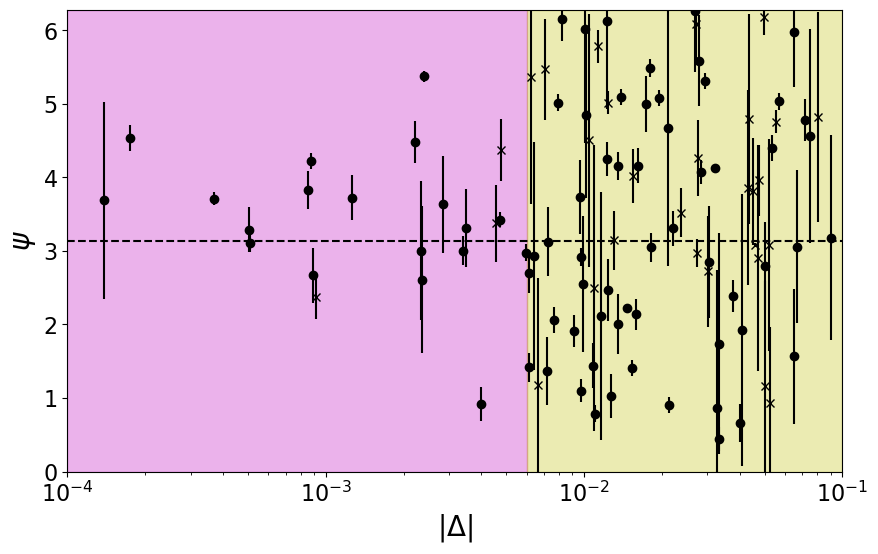

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.errorbar(np.abs(Y1_df.query('Delta < 0')['Delta']), Y1_df.query('Delta < 0')['psi_mean'], yerr=Y1_df.query('Delta < 0')['psi_std'], marker='x', c='k', linestyle='None')#, lw=1)
ax.errorbar(np.abs(Y1_df.query('Delta > 0')['Delta']), Y1_df.query('Delta > 0')['psi_mean'], yerr=Y1_df.query('Delta > 0')['psi_std'], marker='o', c='k', linestyle='None')#, lw=1)
ax.axhline(np.pi, c='k', linestyle='--')
ax.fill_between([1e-4,0.006], 0, 2*np.pi, color='m', alpha=0.3)
ax.fill_between([0.006,1e-1], 0, 2*np.pi, color='y', alpha=0.3)
ax.set_xscale('log')
ax.set_ylim(0, 2*np.pi)
ax.set_xlim(1e-4, 1e-1)
ax.set_xlabel('$|\Delta|$', fontsize=20)
ax.set_ylabel('$\psi$', fontsize=20)
# plt.savefig('figs/delta_psi.pdf')
print(f"{np.sum(np.abs(Y1_df['Delta']) < 0.006)} of {len(Y1_df)} systems below critical |Delta|")

## Split by size

31 of 105 systems with at least one planet with R > 4 Re
2.5549999999999997


Text(0, 0.5, '$\\psi$')

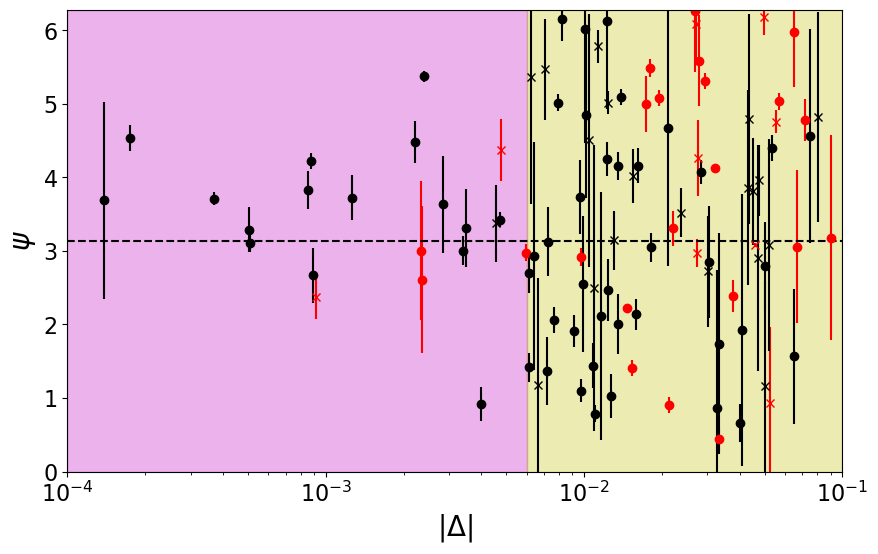

In [9]:
thres_radius = 4
big_planets = Y1_df[(Y1_df['R_inner'] > thres_radius) | (Y1_df['R_outer'] > thres_radius)]
small_planets = Y1_df[(Y1_df['R_inner'] < thres_radius) & (Y1_df['R_outer'] < thres_radius)]
print(f"{len(big_planets)} of {len(Y1_df)} systems with at least one planet with R > {thres_radius} Re")
print(pd.concat((Y1_df['R_inner'], Y1_df['R_outer'])).median())
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# ax.errorbar(np.abs(Y1_df.query('Delta < 0')['Delta']), Y1_df.query('Delta < 0')['psi_mean'], yerr=Y1_df.query('Delta < 0')['psi_std'], marker='x', c='k', linestyle='None')#, lw=1)
# ax.errorbar(np.abs(Y1_df.query('Delta > 0')['Delta']), Y1_df.query('Delta > 0')['psi_mean'], yerr=Y1_df.query('Delta > 0')['psi_std'], marker='o', c='k', linestyle='None')#, lw=1)
ax.errorbar(np.abs(big_planets.query('Delta < 0')['Delta']), big_planets.query('Delta < 0')['psi_mean'], yerr=big_planets.query('Delta < 0')['psi_std'], marker='x', c='r', linestyle='None')#, lw=1)
ax.errorbar(np.abs(big_planets.query('Delta > 0')['Delta']), big_planets.query('Delta > 0')['psi_mean'], yerr=big_planets.query('Delta > 0')['psi_std'], marker='o', c='r', linestyle='None')#, lw=1)
ax.errorbar(np.abs(small_planets.query('Delta < 0')['Delta']), small_planets.query('Delta < 0')['psi_mean'], yerr=small_planets.query('Delta < 0')['psi_std'], marker='x', c='k', linestyle='None')#, lw=1)
ax.errorbar(np.abs(small_planets.query('Delta > 0')['Delta']), small_planets.query('Delta > 0')['psi_mean'], yerr=small_planets.query('Delta > 0')['psi_std'], marker='o', c='k', linestyle='None')#, lw=1)
ax.axhline(np.pi, c='k', linestyle='--')
ax.fill_between([1e-4,0.006], 0, 2*np.pi, color='m', alpha=0.3)
ax.fill_between([0.006,1e-1], 0, 2*np.pi, color='y', alpha=0.3)
ax.set_xscale('log')
ax.set_ylim(0, 2*np.pi)
ax.set_xlim(1e-4, 1e-1)
ax.set_xlabel('$|\Delta|$', fontsize=20)
ax.set_ylabel('$\psi$', fontsize=20)
# plt.savefig('figs/delta_psi.pdf')

## Split by multiplicity

41 of 105 are near 2:1 resonance


Text(0, 0.5, '$\\psi$')

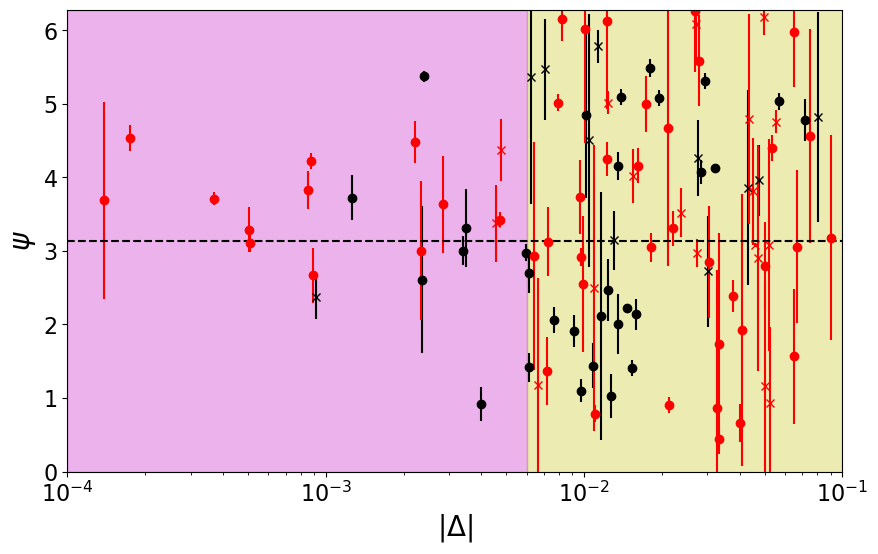

In [10]:
print(f"{np.sum(Y1_df['mult'] == 2)} of {len(Y1_df)} are near 2:1 resonance")
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sub_df = Y1_df.query('mult == 2')
ax.errorbar(np.abs(sub_df.query('Delta < 0')['Delta']), sub_df.query('Delta < 0')['psi_mean'], yerr=sub_df.query('Delta < 0')['psi_std'], marker='x', c='k', linestyle='None')#, lw=1)
ax.errorbar(np.abs(sub_df.query('Delta > 0')['Delta']), sub_df.query('Delta > 0')['psi_mean'], yerr=sub_df.query('Delta > 0')['psi_std'], marker='o', c='k', linestyle='None')#, lw=1)
sub_df = Y1_df.query('mult != 2')
ax.errorbar(np.abs(sub_df.query('Delta < 0')['Delta']), sub_df.query('Delta < 0')['psi_mean'], yerr=sub_df.query('Delta < 0')['psi_std'], marker='x', c='r', linestyle='None')#, lw=1)
ax.errorbar(np.abs(sub_df.query('Delta > 0')['Delta']), sub_df.query('Delta > 0')['psi_mean'], yerr=sub_df.query('Delta > 0')['psi_std'], marker='o', c='r', linestyle='None')#, lw=1)
ax.axhline(np.pi, c='k', linestyle='--')
ax.fill_between([1e-4,0.006], 0, 2*np.pi, color='m', alpha=0.3)
ax.fill_between([0.006,1e-1], 0, 2*np.pi, color='y', alpha=0.3)
ax.set_xscale('log')
ax.set_ylim(0, 2*np.pi)
ax.set_xlim(1e-4, 1e-1)
ax.set_xlabel('$|\Delta|$', fontsize=20)
ax.set_ylabel('$\psi$', fontsize=20)

## Split by resonant index

105 total systems
res
2:1    40
3:2    37
4:3    15
5:4     9
6:5     1
7:6     3
dtype: int64


Text(0, 0.5, '$\\psi$')

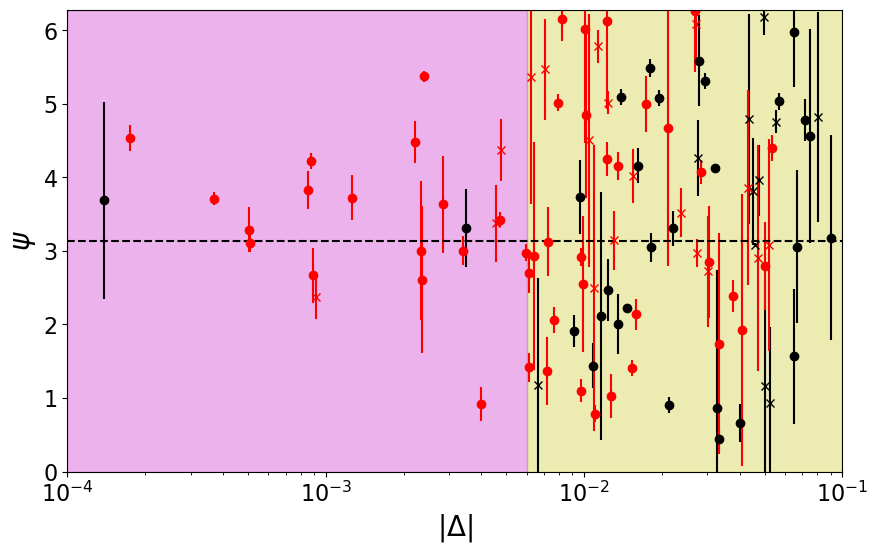

In [11]:
print(f'{len(Y1_df)} total systems')
print(Y1_df.groupby('res').size())
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sub_df = Y1_df.query('res == "2:1"')
ax.errorbar(np.abs(sub_df.query('Delta < 0')['Delta']), sub_df.query('Delta < 0')['psi_mean'], yerr=sub_df.query('Delta < 0')['psi_std'], marker='x', c='k', linestyle='None')#, lw=1)
ax.errorbar(np.abs(sub_df.query('Delta > 0')['Delta']), sub_df.query('Delta > 0')['psi_mean'], yerr=sub_df.query('Delta > 0')['psi_std'], marker='o', c='k', linestyle='None')#, lw=1)
sub_df = Y1_df.query('res != "2:1"')
ax.errorbar(np.abs(sub_df.query('Delta < 0')['Delta']), sub_df.query('Delta < 0')['psi_mean'], yerr=sub_df.query('Delta < 0')['psi_std'], marker='x', c='r', linestyle='None')#, lw=1)
ax.errorbar(np.abs(sub_df.query('Delta > 0')['Delta']), sub_df.query('Delta > 0')['psi_mean'], yerr=sub_df.query('Delta > 0')['psi_std'], marker='o', c='r', linestyle='None')#, lw=1)
ax.axhline(np.pi, c='k', linestyle='--')
ax.fill_between([1e-4,0.006], 0, 2*np.pi, color='m', alpha=0.3)
ax.fill_between([0.006,1e-1], 0, 2*np.pi, color='y', alpha=0.3)
ax.set_xscale('log')
ax.set_ylim(0, 2*np.pi)
ax.set_xlim(1e-4, 1e-1)
ax.set_xlabel('$|\Delta|$', fontsize=20)
ax.set_ylabel('$\psi$', fontsize=20)

## Eccentricity

In [12]:
Y1_df['Z_proj'] = (np.conj(Y1_df['Z_all'].apply(np.median))/np.abs(Y1_df['Z_all'].apply(np.median))*Y1_df['Z_all']).apply(np.real)
Y1_df['Z_proj_sig'] = Y1_df['Z_proj'].apply(lambda x: np.percentile(x, 16)) > 0

In [13]:
def get_error_bars(x):
    return np.abs(np.percentile(x, [16, 84]) - np.median(x))

Text(0, 0.5, '$|\\mathcal{Z}|$')

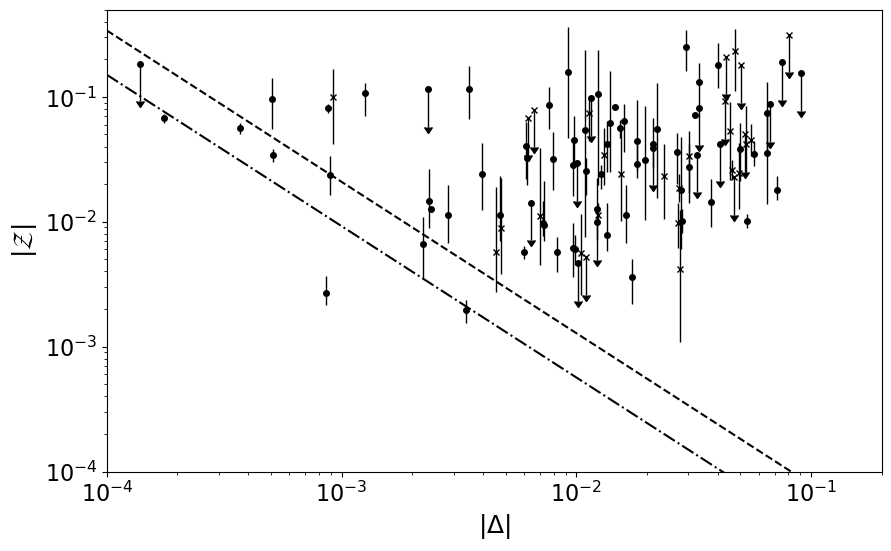

In [14]:
plt.figure(figsize=(10,6))
for sub_df, marker in zip([Y1_df.query('Delta > 0'), Y1_df.query('Delta < 0')], ['o', 'x']):
    plt.errorbar(np.abs(sub_df[sub_df['Z_proj_sig']]['Delta']), sub_df[sub_df['Z_proj_sig']]['Zabs_med'], 
                yerr=np.array(list(map(get_error_bars, sub_df[sub_df['Z_proj_sig']]['Zabs_all']))).T, 
                marker=marker, c='k', linestyle='None', lw=1, markersize=4)
    plt.errorbar(np.abs(sub_df[~sub_df['Z_proj_sig']]['Delta']), list(map(lambda x: np.percentile(x, 95), sub_df[~sub_df['Z_proj_sig']]['Zabs_all'])), 
                yerr=0.5*np.array(list(map(lambda x: np.percentile(x, 95), sub_df[~sub_df['Z_proj_sig']]['Zabs_all']))), 
                marker=marker, c='k', linestyle='None', lw=1, markersize=4, uplims=True)
plt.plot(np.logspace(-4, np.log10(2e-1), 100), (4/5)*(20/332900)/np.logspace(-4, 0, 100)/np.sqrt(2), c='k', linestyle='--') # compact limit forced eccentricity
plt.plot(np.logspace(-4, np.log10(2e-1), 100), (1/4)*(20/332900)/np.logspace(-4, 0, 100), c='k', linestyle='-.') # 2:1 resonance forced eccentricity
plt.xlim(1e-4, 2e-1)
plt.ylim(1e-4, 5e-1)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('$|\Delta|$', fontsize=18)
plt.ylabel('$|\mathcal{Z}|$', fontsize=18)
# plt.savefig('figs/Delta_Z.pdf')

Text(0, 0.5, '$\\mathcal{Z}_{proj}$')

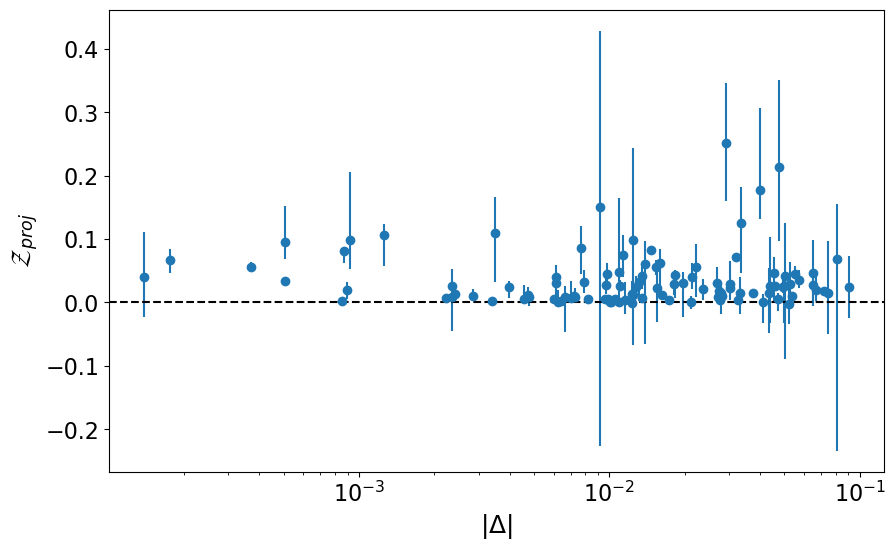

In [23]:
plt.figure(figsize=(10,6))
plt.errorbar(np.abs(Y1_df['Delta']), Y1_df['Z_proj'].apply(np.median), 
             yerr=np.array(list(map(lambda x: np.abs(np.percentile(x, [16, 84]) - np.median(x)), Y1_df['Z_all']))).T, 
             linestyle='None', marker='o')
plt.axhline(0, c='k', linestyle='--')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$|\Delta|$', fontsize=18)
plt.ylabel('$\mathcal{Z}_{proj}$', fontsize=18)

## Statistical Tests

22 83
0.9098
Median p-value: 0.005808570862026547
Harmonic mean p-value: 0.0007131867835244606


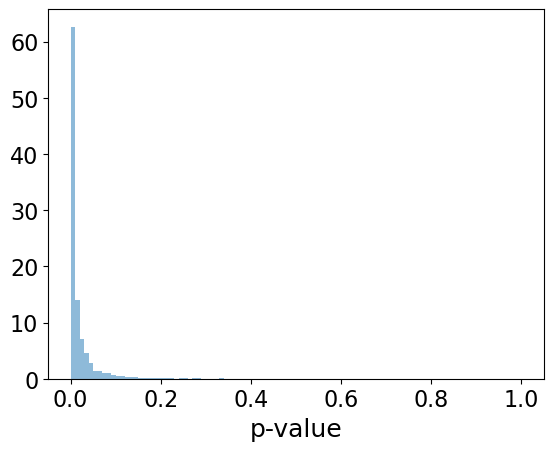

In [24]:
Delta_threshold = 0.006
sample_1 = Y1_df[np.abs(Y1_df['Delta']) < Delta_threshold]
sample_2 = Y1_df[np.abs(Y1_df['Delta']) > Delta_threshold]
print(len(sample_1), len(sample_2))

p_vals = [kuiper_two([np.random.choice(psi_) for psi_ in sample_1['psi_all']], 
                     [np.random.choice(psi_) for psi_ in sample_2['psi_all']])[1] for i in range(10000)]
p_vals = np.array(p_vals)
# rarely the Kuiper test seems to report very small but negative p-values
p_vals = p_vals[p_vals > 0]
plt.hist(p_vals, bins=100, alpha=0.5, density=True, range=(0, 1))
plt.xlabel('p-value', fontsize=18)
print(sum(p_vals < 0.05)/len(p_vals))
print('Median p-value:', np.median(p_vals))
print('Harmonic mean p-value:', 1/np.mean(1/p_vals))

(-0.02, 1.02)

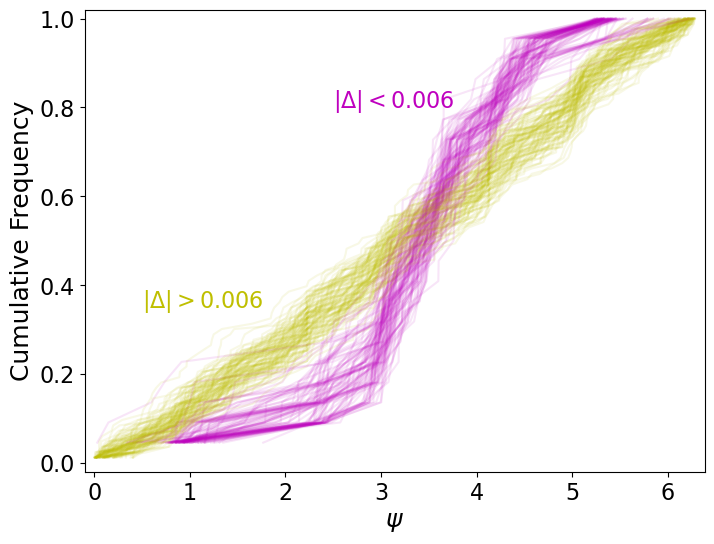

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i in range(100):
    ax.plot(*ecdf([np.random.choice(psi_) for psi_ in sample_1['psi_all']]), c='m', alpha=0.1)
    ax.plot(*ecdf([np.random.choice(psi_) for psi_ in sample_2['psi_all']]), c='y', alpha=0.1)
# ax.vlines(np.pi, 0, 1, linestyle='--', color='k')
ax.set_xlabel('$\psi$', fontsize=18)
ax.set_ylabel('Cumulative Frequency', fontsize=18)
ax.text(2.5, 0.8, f'$|\Delta| < {Delta_threshold}$', c='m')
ax.text(0.5, 0.35, f'$|\Delta| > {Delta_threshold}$', c='y')
ax.set_xlim(-0.1, 2*np.pi+0.1)
ax.set_ylim(-0.02, 1.02)
# plt.savefig('figs/psi_cdfs.pdf')

Text(0, 0.5, 'Density')

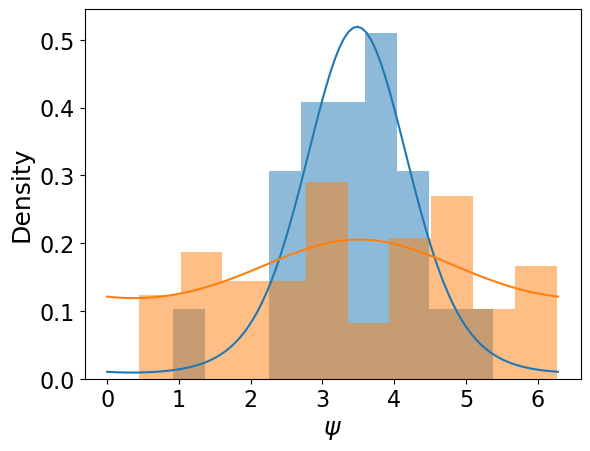

In [18]:
vm_1 = vonmises.fit(sample_1['psi_mean'], fscale=1)
vm_2 = vonmises.fit(sample_2['psi_mean'], fscale=1)
plt.hist(sample_1['psi_mean'], bins=10, alpha=0.5, density=True)
plt.hist(sample_2['psi_mean'], bins=10, alpha=0.5, density=True)
plt.plot(np.linspace(0, 2*np.pi, 100), vonmises.pdf(np.linspace(0, 2*np.pi, 100), *vm_1), c='C0')
plt.plot(np.linspace(0, 2*np.pi, 100), vonmises.pdf(np.linspace(0, 2*np.pi, 100), *vm_2), c='C1')
plt.xlabel('$\psi$', fontsize=18)
plt.ylabel('Density', fontsize=18)

## Trying to measure $\delta$

Harmonic mean p-value for delta: 0.4645


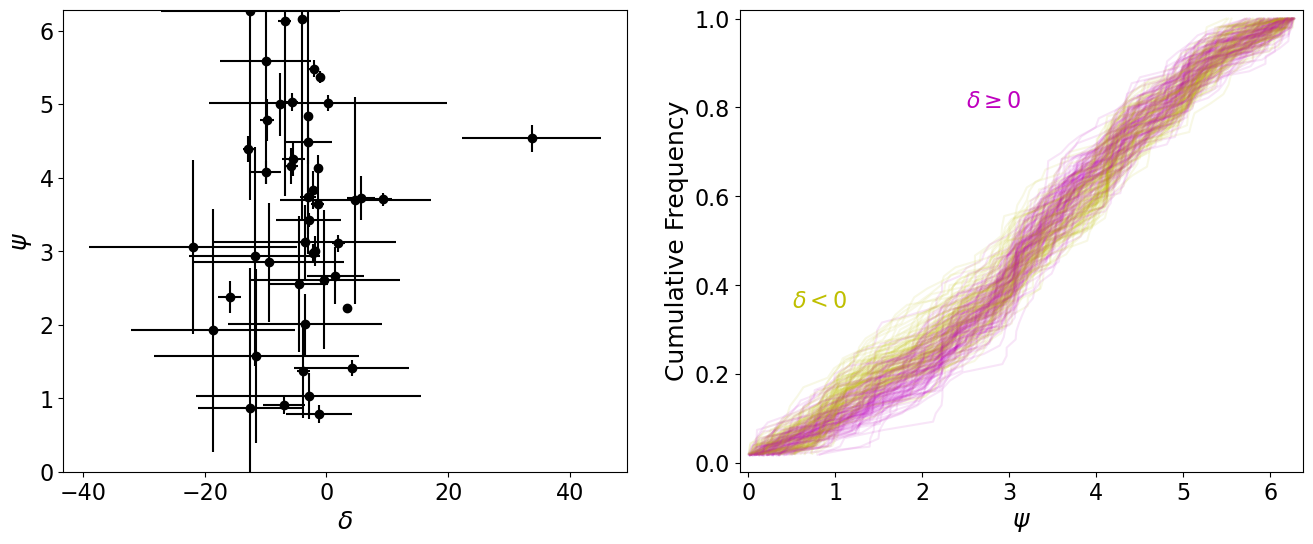

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
good_deltas = (np.array(list(map(np.std, Y1_df['delta_all']))) < 20) & (Y1_df['Delta'] > 0)
axs[0].errorbar(list(map(np.median, Y1_df[good_deltas]['delta_all'])), Y1_df[good_deltas]['psi_mean'], marker='o', 
                xerr=list(map(np.std, Y1_df[good_deltas]['delta_all'])), yerr=list(map(np.std, Y1_df[good_deltas]['psi_all'])), c='k',
                linestyle='None')
axs[0].set_xlabel('$\delta$', fontsize=18)
axs[0].set_ylabel('$\psi$', fontsize=18)
# plt.xlim(-30, 30)
axs[0].set_ylim(0, 2*np.pi)

p_vals_delta = []
for i in range(100):
    psis_, deltas_ = [], []
    for _, (psi_, delta_) in Y1_df[['psi_all', 'delta_all']].iterrows():
        # do one draw of each posterior
        j = np.random.randint(len(psi_))
        psis_.append(psi_[j])
        deltas_.append(delta_[j])
    psis_ = np.array(psis_)
    deltas_ = np.array(deltas_)
    axs[1].plot(*ecdf(psis_[deltas_ >= 0]), c='m', alpha=0.1)
    axs[1].plot(*ecdf(psis_[deltas_ < 0]), c='y', alpha=0.1)
    p_vals_delta.append(kuiper_two(psis_[deltas_ > 0], psis_[deltas_ < 0])[1])
axs[1].set_xlabel('$\psi$', fontsize=18)
axs[1].set_ylabel('Cumulative Frequency', fontsize=18)
axs[1].set_xlim(-0.1, 2*np.pi+0.1)
axs[1].set_ylim(-0.02, 1.02)
axs[1].text(2.5, 0.8, f'$\delta \geq 0$', c='m')
axs[1].text(0.5, 0.35, f'$\delta < 0$', c='y')
p_vals_delta = np.array(p_vals_delta)
print(f'Harmonic mean p-value for delta: {1/np.mean(1/p_vals_delta):.4f}')